## PCA Loss Landscapes

An approach for computing and visualizing 3D loss landscapes for high-dimensional models.

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

### Classifiers

#### Logistic Regression

In [82]:
class LogisticRegression():
    
    def loss(self, X, y, theta):
        YX = X * y[:,None]
        hy = YX @ theta
        loss = np.log(1+np.exp(-hy)).mean()
        error = (hy <= 0).mean()
        return loss, error
    
    def gradient(self, X, y, theta):
        YX = X * y[:,None]
        m = X.shape[0]
        gradient = -YX.T @ (1/(1+np.exp(YX @ theta)))/m
        return gradient

    def gradient_descent(self, X, y, alpha, iters):
        m,n = X.shape
        theta = np.zeros((iters+1, n))
        loss, err = np.zeros(iters), np.zeros(iters)
        for t in range(iters):
            loss[t], err[t] = self.loss(X, y, theta[t])
            theta[t+1] -= alpha * self.gradient(X, y, theta[t])
        theta = theta[0:iters, :]
        return theta, loss, err

#### SVM

In [83]:
class SVM():
  
    def loss(self, X, y, theta):
        YX = X * y[:,None]
        hy = YX @ theta
        loss = np.maximum(1-hy,0).mean()
        error = (hy <= 0).mean()
        return loss, error
    
    def gradient(self, X, y, theta):
        YX = X * y[:,None]
        m = X.shape[0]
        gradient = -YX.T @ (YX @ theta <= 1)/m
        return gradient

    def gradient_descent(self, X, y, alpha, iters):
        m,n = X.shape
        theta = np.zeros((iters+1, n))
        loss, err = np.zeros(iters), np.zeros(iters)
        for t in range(iters):
            loss[t], err[t] = self.loss(X, y, theta[t])
            theta[t+1] -= alpha * self.gradient(X, y, theta[t])
        theta = theta[0:iters, :]
        return theta, loss, err

#### Neural Network

In [87]:
def nn(x, W, b, f):
    """
    Compute output of a neural network.

    Input:
        x: numpy array of input
        W: list of numpy arrays for W parameters
        b: list of numpy arraos for b parameters
        f: list of activation functions for each layer

    Output:
        z: list of activationsn, where each element in the list is a tuple:
           (z_i, z'_i)
           for z_i and z'_i each being a numpy array of activations/derivatives
    """

    z = [(x,)] + [[]]*len(W)
    for i in range(len(W)):
        z[i+1] = (f[i](W[i] @ z[i][0] + b[i])[0],
                  f[i](W[i] @ z[i][0] + b[i])[1])
    return z


In [88]:
def nn_loss(x, y, W, b, f):
    """
    Compute loss of a neural net prediction, plus gradients of parameters

    Input:
        x: numpy array of input
        y: numpy array of output
        W: list of numpy arrays for W parameters
        b: list of numpy arrays for b parameters
        f: list of activation functions for each layer

    Output tuple: (L, dW, db)
        L: softmax loss on this example
        dW: list of numpy arrays for gradients of W parameters
        db: list of numpy arrays for gradients of b parameters
    """

    z = nn(x,W,b,f)
    L, dL = softmax_loss(z[-1][0], y)
    
    db = [np.zeros(bi.shape) for bi in b]
    dW = [np.zeros(Wi.shape) for Wi in W]
    
    g = dL
    db[-1] = g * z[-1][1]
    dW[-1] = (g * z[-1][1])[:,None] @ z[-2][0][None,:]
    
    for i in range(len(db)-2, -1, -1):
        g = W[i+1].T @ (g * z[i+2][1])
        db[i] = g * z[i+1][1]
        dW[i] = (g * z[i+1][1])[:,None] @ z[i][0][None,:]

    return L, dW, db


In [86]:
def nn_sgd(X,y, Xt, yt, W, b, f, epochs=10, alpha = 0.01):
    """
    Run stochastic gradient descent to solve linear softmax regression.

    Inputs:
        X: numpy array of training inputs
        y: numpy array of training outputs
        Xt: numpy array of testing inputs
        yt: numpy array of testing outputs
        W: list of W parameters (with initial values)
        b: list of b parameters (with initial values)
        f: list of activation functions
        epochs: number of passes to make over the whole training set
        alpha: step size

    Output: None (you can directly update the W and b inputs in place)
    """
    m = X.shape[0]
    print("{0:10}|{1:10}|{2:10}|{3:10}".\
          format("Test Err", "Train Err", "Test Loss", "Train Loss"))

    # TODO: Modify W and b in-place.
    for i in range(epochs):
        yp = np.vstack([nn(x, W, b, f)[-1][0] for x in X_train])
        ypt = np.vstack([nn(x, W, b, f)[-1][0] for x in X_test])
        print_errors(yp, y, ypt, yt)
        for i in range(m):
            x_i = X_train[i]
            y_i = y_train[i]
            L, dW, db = nn_loss(x_i, y_i, W, b, f)
            for j in range(len(W)):
                b[j] -= alpha * db[j]
                W[j] -= alpha * dW[j]


In [ ]:
np.random.seed(0)
layer_sizes = [784, 200, 100, 10]
W = [0.1*np.random.randn(n,m) for m,n in zip(layer_sizes[:-1], layer_sizes[1:])]
b = [0.1*np.random.randn(n) for n in layer_sizes[1:]]
f = [f_relu]*(len(layer_sizes)-2) + [f_lin]

z = nn(X_train[0], W, b, f)

L, dW, db = nn_loss(X_train[0], y_train[0], W, b, f)

# # nn_sgd should update W and b in-place.
nn_sgd(X_train, y_train, X_test, y_test, W, b, f, epochs=10, alpha=0.01)

### Dataset: Iris

In [4]:
df = pd.read_table('data/iris.data.txt', sep=',', 
                   names=['sepal length', 'sepal width', 'petal length', 'petal width', 'label'])
df = df[df['label'].isin(['Iris-setosa', 'Iris-versicolor'])]   # only keep 2 classes
df = df.reset_index(drop=True)
print('Dimensions:', df.shape)
df.head()

Dimensions: (100, 5)


,sepal length,sepal width,petal length,petal width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#### Train a logistic regression model

In [5]:
X = df.iloc[:,0:4].as_matrix()
y = ((df['label'] == 'Iris-setosa') * 2 - 1).as_matrix()   # convert to 1 / -1 labels
lr_model = LogisticRegression()
theta, loss, err = lr_model.gradient_descent(X, y, 0.1, 10)

In [6]:
print(theta.shape)
theta

(10, 4)


array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.02325   ,  0.0162    , -0.0699    , -0.02705   ],
       [ 0.01879636,  0.03809277, -0.04415203, -0.01947855],
       [-0.03321116,  0.00939328, -0.07283334, -0.02755924],
       [ 0.03004878,  0.0443948 , -0.03812783, -0.01780393],
       [-0.04699927,  0.00178074, -0.08042985, -0.02969857],
       [ 0.04605124,  0.05328839, -0.02942701, -0.01536844],
       [-0.06642621, -0.00893673, -0.0911488 , -0.03271901],
       [ 0.06766382,  0.06533566, -0.01774751, -0.01210876],
       [-0.09191999, -0.02300177, -0.10521241, -0.03668105]])

Projecting the theta parameters down to 2 dimensions through PCA.

In [7]:
theta = (theta - theta.mean(axis=0)) / theta.std(axis=0)   # normalizing theta before PCA

pca = PCA(n_components=2)
theta_reduced = pca.fit_transform(theta)
theta_reduced = pd.DataFrame(theta_reduced, columns=['theta_0', 'theta_1'])

theta_reduced.head()

,theta_0,theta_1
0,-1.674022,2.230784
1,0.685030,-0.288320
2,-0.903374,-0.372944
3,0.978016,-0.122944
4,-1.305652,-0.435362


Text(0,0.5,'PC theta 1')

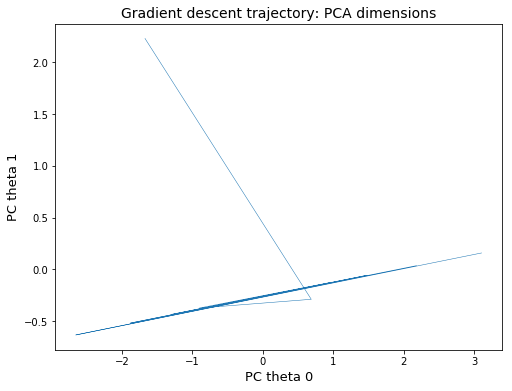

In [8]:
plt.figure(figsize=(8,6))
plt.plot(theta_reduced["theta_0"], theta_reduced["theta_1"], lw=0.5)
plt.title("Gradient descent trajectory: PCA dimensions", fontsize=14)
plt.xlabel("PC theta 0", fontsize=13)
plt.ylabel("PC theta 1", fontsize=13)

Creating a dense grid of points centered around the thetas from each iteration of gradient descent. These sampled points will be used for evaluating loss in their regions.

Text(0,0.5,'PC theta 1')

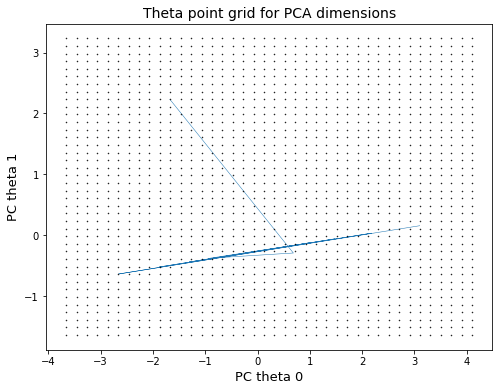

In [9]:
plt.figure(figsize=(8,6))
plt.plot(theta_reduced["theta_0"], theta_reduced["theta_1"], lw=0.5)

num_samples = 40
offset = 1
min_theta_0, min_theta_1 = theta_reduced["theta_0"].min(), theta_reduced["theta_1"].min()
max_theta_0, max_theta_1 = theta_reduced["theta_0"].max(), theta_reduced["theta_1"].max()
theta_0_range = np.linspace(min_theta_0 - offset, max_theta_0 + offset, num_samples)
theta_1_range = np.linspace(min_theta_1 - offset, max_theta_1 + offset, num_samples)
theta_0_points, theta_1_points = np.meshgrid(theta_0_range, theta_1_range)
plt.plot(theta_0_points, theta_1_points, '.', ms=1, color='k')
plt.title("Theta point grid for PCA dimensions", fontsize=14)
plt.xlabel("PC theta 0", fontsize=13)
plt.ylabel("PC theta 1", fontsize=13)

Create a matrix of the 2D grid of points.

In [10]:
all_theta_points_2D = []
for theta_0 in theta_0_range:
    for theta_1 in theta_1_range:
        all_theta_points_2D.append([theta_0, theta_1])
all_theta_points_2D = np.array(all_theta_points_2D)
print(all_theta_points_2D.shape)
print(all_theta_points_2D)

(1600, 2)
[[-3.65669527 -1.63290613]
 [-3.65669527 -1.50819611]
 [-3.65669527 -1.3834861 ]
 ...
 [ 4.10181574  2.98136435]
 [ 4.10181574  3.10607437]
 [ 4.10181574  3.23078438]]


Project theta parameters from the 2D points back into their original space.

In [11]:
all_theta_points_projected = pca.inverse_transform(all_theta_points_2D)
print(all_theta_points_projected.shape)
print(all_theta_points_projected)

(1600, 4)
[[ 2.4262801   2.78428301  1.29746813  0.84576127]
 [ 2.38830994  2.70111609  1.34359274  0.91694159]
 [ 2.35033977  2.61794916  1.38971735  0.9881219 ]
 ...
 [-3.07166817 -3.88991409 -1.03018773 -0.29250982]
 [-3.10963833 -3.97308102 -0.98406312 -0.22132951]
 [-3.1476085  -4.05624794 -0.93793851 -0.1501492 ]]


Compute loss from projected theta values.

In [12]:
grid_rows, grid_cols = theta_0_points.shape
loss = np.zeros((grid_rows, grid_cols))
for i in range(grid_rows):
    for j in range(grid_cols):
        theta_ij = all_theta_points_projected[i*grid_rows + j]
        loss[i, j] = lr_model.loss(X, y, theta_ij)[0]
print(loss.shape)
loss

(40, 40)


array([[14.38177816, 14.29933449, 14.21689082, ..., 11.33142454,
        11.24900979, 11.16660869],
       [13.65808999, 13.57564632, 13.49320265, ..., 10.60783776,
        10.52547071, 10.4431401 ],
       [12.93440183, 12.85195816, 12.76951449, ...,  9.88441878,
         9.8021793 ,  9.72003752],
       ...,
       [ 6.9055654 ,  7.10028952,  7.29501371, ..., 14.11036667,
        14.30509105, 14.49981543],
       [ 7.41339765,  7.60812193,  7.80284624, ..., 14.61819945,
        14.81292383, 15.00764821],
       [ 7.92123022,  8.11595456,  8.31067892, ..., 15.12603223,
        15.32075661, 15.51548099]])

Visualizing the loss landscape with a 3D plot.



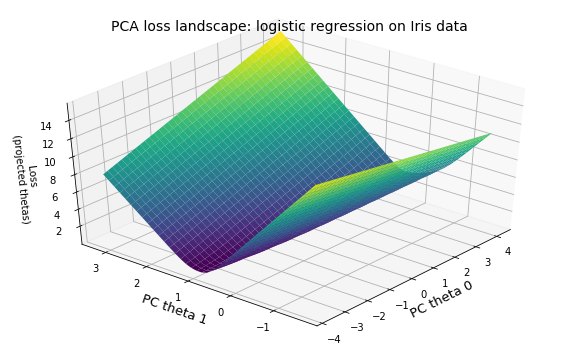

In [13]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

ax.plot_surface(theta_0_points, theta_1_points, loss, cmap='viridis')
ax.set_title('PCA loss landscape: logistic regression on Iris data',
             fontsize=14)
ax.set_xlabel('PC theta 0', fontsize=13)
ax.set_ylabel('PC theta 1', fontsize=13)
ax.set_zlabel('Loss \n(projected thetas)')
ax.view_init(40, 220)

Saving theta and loss point values

In [14]:
df = pd.DataFrame({'theta_0': theta_0_points.reshape(num_samples**2),
                   'theta_1': theta_1_points.reshape(num_samples**2),
                   'loss': loss.reshape(num_samples**2)},
                  columns = ['theta_0', 'theta_1', 'loss'])
df.to_csv('data/PCA_loss_LR_iris.csv', index=False)
df.head()

,theta_0,theta_1,loss
0,-3.656695,-1.632906,14.381778
1,-3.457759,-1.632906,14.299334
2,-3.258823,-1.632906,14.216891
3,-3.059887,-1.632906,14.134447
4,-2.860951,-1.632906,14.052003


#### Train an SVM model

In [15]:
svm_model = SVM()
theta, loss, err = svm_model.gradient_descent(X, y, 0.1, 10)

Projecting the theta parameters down to 2 dimensions through PCA.

In [16]:
theta = (theta - theta.mean(axis=0)) / theta.std(axis=0)   # normalizing theta before PCA

pca = PCA(n_components=2)
theta_reduced = pca.fit_transform(theta)
theta_reduced = pd.DataFrame(theta_reduced, columns=['theta_0', 'theta_1'])

Creating a dense grid of points centered around the thetas from each iteration of gradient descent. These sampled points will be used for evaluating loss in their regions.

Text(0,0.5,'PC theta 1')

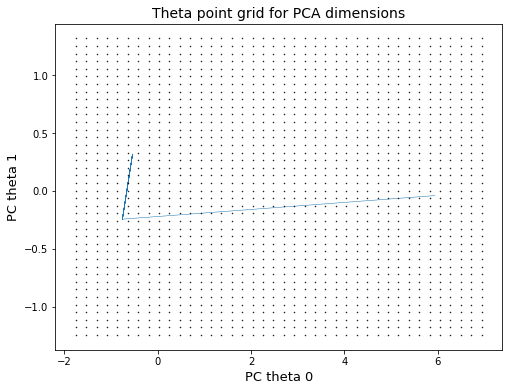

In [17]:
plt.figure(figsize=(8,6))
plt.plot(theta_reduced["theta_0"], theta_reduced["theta_1"], lw=0.5)

num_samples = 40
offset = 1
min_theta_0, min_theta_1 = theta_reduced["theta_0"].min(), theta_reduced["theta_1"].min()
max_theta_0, max_theta_1 = theta_reduced["theta_0"].max(), theta_reduced["theta_1"].max()
theta_0_range = np.linspace(min_theta_0 - offset, max_theta_0 + offset, num_samples)
theta_1_range = np.linspace(min_theta_1 - offset, max_theta_1 + offset, num_samples)
theta_0_points, theta_1_points = np.meshgrid(theta_0_range, theta_1_range)
plt.plot(theta_0_points, theta_1_points, '.', ms=1, color='k')
plt.title("Theta point grid for PCA dimensions", fontsize=14)
plt.xlabel("PC theta 0", fontsize=13)
plt.ylabel("PC theta 1", fontsize=13)

Create a matrix of the 2D grid of points.

In [18]:
all_theta_points_2D = []
for theta_0 in theta_0_range:
    for theta_1 in theta_1_range:
        all_theta_points_2D.append([theta_0, theta_1])
all_theta_points_2D = np.array(all_theta_points_2D)

Project theta parameters from the 2D points back into their original space.

In [19]:
all_theta_points_projected = pca.inverse_transform(all_theta_points_2D)

Compute loss from projected theta values.

In [20]:
grid_rows, grid_cols = theta_0_points.shape
loss = np.zeros((grid_rows, grid_cols))
for i in range(grid_rows):
    for j in range(grid_cols):
        theta_ij = all_theta_points_projected[i*grid_rows + j]
        loss[i, j] = svm_model.loss(X, y, theta_ij)[0]

Visualizing the loss landscape with a 3D plot.



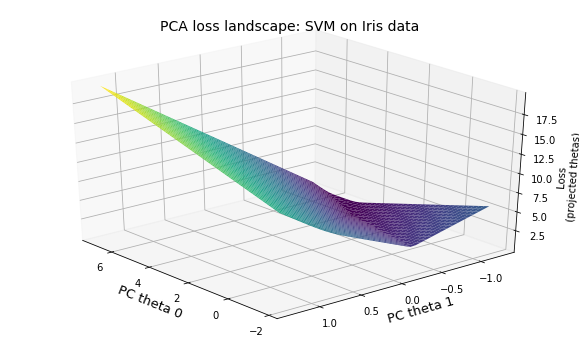

In [21]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

ax.plot_surface(theta_0_points, theta_1_points, loss, cmap='viridis')
ax.set_title('PCA loss landscape: SVM on Iris data',
             fontsize=14)
ax.set_xlabel('PC theta 0', fontsize=13)
ax.set_ylabel('PC theta 1', fontsize=13)
ax.set_zlabel('Loss \n(projected thetas)')
ax.view_init(30, 140)

Saving theta and loss point values

In [22]:
df = pd.DataFrame({'theta_0': theta_0_points.reshape(num_samples**2),
                   'theta_1': theta_1_points.reshape(num_samples**2),
                   'loss': loss.reshape(num_samples**2)},
                  columns = ['theta_0', 'theta_1', 'loss'])
df.to_csv('data/PCA_loss_SVM_iris.csv', index=False)

### Dataset: Breast Cancer

In [36]:
df = pd.read_csv("data/breast-cancer.csv")
df = df.drop(['id', 'Unnamed: 32'], axis=1)
print('Dimensions:', df.shape)
df.head()


Dimensions: (569, 31)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### Train a logistic regression model

In [50]:
X = df.iloc[:,1:31].as_matrix()
X = (X - X.mean(axis=0))/X.std(axis=0)
y = ((df['diagnosis'] == 'M') * 2 - 1).as_matrix()   # convert to 1 / -1 labels
lr_model = LogisticRegression()
theta, loss, err = lr_model.gradient_descent(X, y, 0.1, 10)

In [51]:
print(theta.shape)
theta

(10, 30)


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.03529633,  0.0200739 ,  0.03590587,  0.03427884,  0.01733611,
         0.02884196,  0.03366847,  0.0375487 ,  0.01597936, -0.00062069,
         0.0274205 , -0.00040146,  0.02688899,  0.0265068 , -0.00324017,
         0.01416629,  0.01226764,  0.01972854, -0.00031532,  0.00376991,
         0.03754096,  0.02209091,  0.03785331,  0.03547989,  0.02037751,
         0.02857432,  0.03189166,  0.03836832,  0.02012752,  0.01565898],
       [ 0.0252794 ,  0.01519728,  0.02557932,  0.02429302,  0.01161367,
         0.01895306,  0.02281717,  0.02625529,  0

Projecting the theta parameters down to 2 dimensions through PCA.

In [52]:
theta = (theta - theta.mean(axis=0)) / theta.std(axis=0)   # normalizing theta before PCA

pca = PCA(n_components=2)
theta_reduced = pca.fit_transform(theta)
theta_reduced = pd.DataFrame(theta_reduced, columns=['theta_0', 'theta_1'])

theta_reduced.head()

,theta_0,theta_1
0,15.146609,1.274547
1,-5.848976,3.954198
2,-0.056786,-2.268323
3,-1.628750,0.119372
4,-1.181466,-0.676763


Text(0,0.5,'PC theta 1')

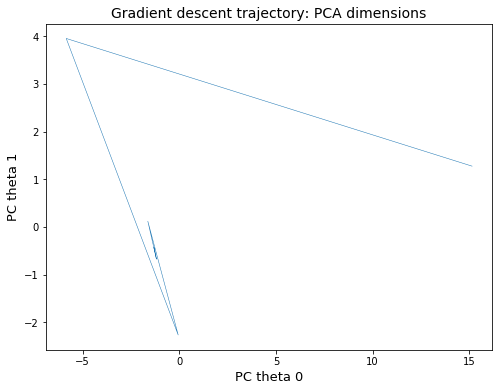

In [53]:
plt.figure(figsize=(8,6))
plt.plot(theta_reduced["theta_0"], theta_reduced["theta_1"], lw=0.5)
plt.title("Gradient descent trajectory: PCA dimensions", fontsize=14)
plt.xlabel("PC theta 0", fontsize=13)
plt.ylabel("PC theta 1", fontsize=13)

Creating a dense grid of points centered around the thetas from each iteration of gradient descent. These sampled points will be used for evaluating loss in their regions.

Text(0,0.5,'PC theta 1')

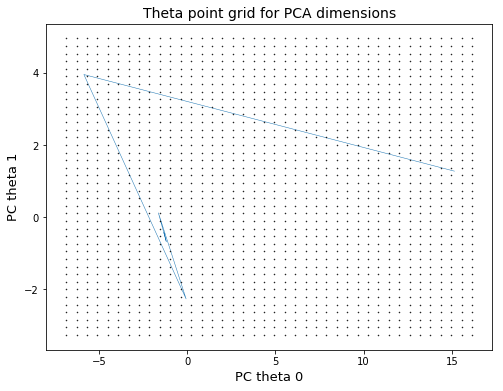

In [54]:
plt.figure(figsize=(8,6))
plt.plot(theta_reduced["theta_0"], theta_reduced["theta_1"], lw=0.5)

num_samples = 40
offset = 1
min_theta_0, min_theta_1 = theta_reduced["theta_0"].min(), theta_reduced["theta_1"].min()
max_theta_0, max_theta_1 = theta_reduced["theta_0"].max(), theta_reduced["theta_1"].max()
theta_0_range = np.linspace(min_theta_0 - offset, max_theta_0 + offset, num_samples)
theta_1_range = np.linspace(min_theta_1 - offset, max_theta_1 + offset, num_samples)
theta_0_points, theta_1_points = np.meshgrid(theta_0_range, theta_1_range)
plt.plot(theta_0_points, theta_1_points, '.', ms=1, color='k')
plt.title("Theta point grid for PCA dimensions", fontsize=14)
plt.xlabel("PC theta 0", fontsize=13)
plt.ylabel("PC theta 1", fontsize=13)

Create a matrix of the 2D grid of points.

In [55]:
all_theta_points_2D = []
for theta_0 in theta_0_range:
    for theta_1 in theta_1_range:
        all_theta_points_2D.append([theta_0, theta_1])
all_theta_points_2D = np.array(all_theta_points_2D)
print(all_theta_points_2D.shape)
print(all_theta_points_2D)

(1600, 2)
[[-6.84897593 -3.26832334]
 [-6.84897593 -3.05748946]
 [-6.84897593 -2.84665558]
 ...
 [16.14660884  4.53253014]
 [16.14660884  4.74336402]
 [16.14660884  4.9541979 ]]


Project theta parameters from the 2D points back into their original space.

In [56]:
all_theta_points_projected = pca.inverse_transform(all_theta_points_2D)
print(all_theta_points_projected.shape)
print(all_theta_points_projected)

(1600, 30)
[[ 1.28356901  1.38395905  1.27419445 ...  1.27725263  1.34151175
   1.17067334]
 [ 1.28486951  1.37872409  1.2760953  ...  1.27895749  1.33906161
   1.17909507]
 [ 1.28617002  1.37348912  1.27799616 ...  1.28066235  1.33661146
   1.18751679]
 ...
 [-3.04561161 -3.18393801 -3.0325449  ... -3.03680528 -3.12577333
  -2.88661721]
 [-3.0443111  -3.18917298 -3.03064404 ... -3.03510042 -3.12822348
  -2.87819548]
 [-3.0430106  -3.19440794 -3.02874319 ... -3.03339556 -3.13067362
  -2.86977376]]


Compute loss from projected theta values.

In [57]:
grid_rows, grid_cols = theta_0_points.shape
loss = np.zeros((grid_rows, grid_cols))
for i in range(grid_rows):
    for j in range(grid_cols):
        theta_ij = all_theta_points_projected[i*grid_rows + j]
        loss[i, j] = lr_model.loss(X, y, theta_ij)[0]
print(loss.shape)
loss

(40, 40)


array([[ 0.24466642,  0.25082205,  0.2599025 , ...,  1.57868329,
         1.63680967,  1.69575911],
       [ 0.22663093,  0.22682084,  0.23152425, ...,  1.55388257,
         1.61365066,  1.67420779],
       [ 0.21523223,  0.2113015 ,  0.21009443, ...,  1.53278744,
         1.59426559,  1.65652708],
       ...,
       [41.52531601, 41.41249797, 41.30046299, ..., 37.9033205 ,
        37.81814762, 37.73395497],
       [43.09160622, 42.97917432, 42.86768737, ..., 39.46851067,
        39.38286561, 39.29776884],
       [44.6581146 , 44.54614953, 44.43522232, ..., 41.0339335 ,
        40.94803256, 40.86244418]])

Visualizing the loss landscape with a 3D plot.



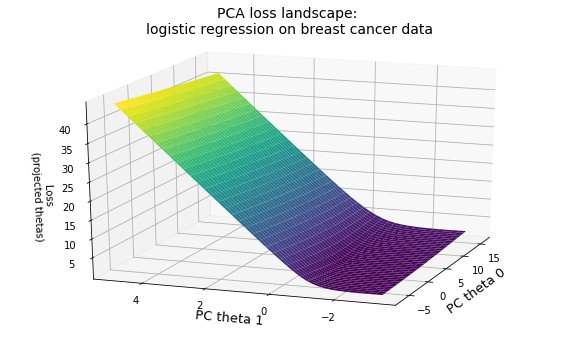

In [67]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

ax.plot_surface(theta_0_points, theta_1_points, loss, cmap='viridis')
ax.set_title('PCA loss landscape: \nlogistic regression on breast cancer data',
             fontsize=14)
ax.set_xlabel('PC theta 0', fontsize=13)
ax.set_ylabel('PC theta 1', fontsize=13)
ax.set_zlabel('Loss \n(projected thetas)')
ax.view_init(20, 200)

Saving theta and loss point values

In [68]:
df = pd.DataFrame({'theta_0': theta_0_points.reshape(num_samples**2),
                   'theta_1': theta_1_points.reshape(num_samples**2),
                   'loss': loss.reshape(num_samples**2)},
                  columns = ['theta_0', 'theta_1', 'loss'])
df.to_csv('data/PCA_loss_LR_cancer.csv', index=False)
df.head()

,theta_0,theta_1,loss
0,-6.848976,-3.268323,0.244666
1,-6.259346,-3.268323,0.250822
2,-5.669715,-3.268323,0.259902
3,-5.080085,-3.268323,0.271114
4,-4.490454,-3.268323,0.284290


#### Train an SVM model

In [69]:
svm_model = SVM()
theta, loss, err = svm_model.gradient_descent(X, y, 0.1, 10)

Projecting the theta parameters down to 2 dimensions through PCA.

In [70]:
theta = (theta - theta.mean(axis=0)) / theta.std(axis=0)   # normalizing theta before PCA

pca = PCA(n_components=2)
theta_reduced = pca.fit_transform(theta)
theta_reduced = pd.DataFrame(theta_reduced, columns=['theta_0', 'theta_1'])

Creating a dense grid of points centered around the thetas from each iteration of gradient descent. These sampled points will be used for evaluating loss in their regions.

Text(0,0.5,'PC theta 1')

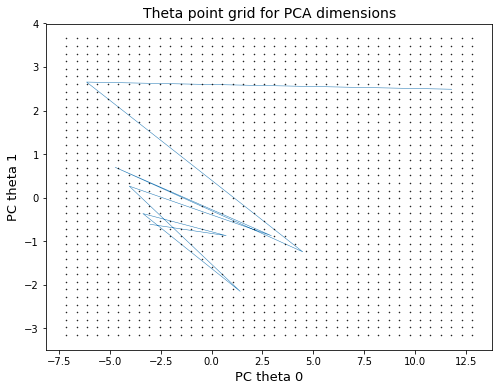

In [71]:
plt.figure(figsize=(8,6))
plt.plot(theta_reduced["theta_0"], theta_reduced["theta_1"], lw=0.5)

num_samples = 40
offset = 1
min_theta_0, min_theta_1 = theta_reduced["theta_0"].min(), theta_reduced["theta_1"].min()
max_theta_0, max_theta_1 = theta_reduced["theta_0"].max(), theta_reduced["theta_1"].max()
theta_0_range = np.linspace(min_theta_0 - offset, max_theta_0 + offset, num_samples)
theta_1_range = np.linspace(min_theta_1 - offset, max_theta_1 + offset, num_samples)
theta_0_points, theta_1_points = np.meshgrid(theta_0_range, theta_1_range)
plt.plot(theta_0_points, theta_1_points, '.', ms=1, color='k')
plt.title("Theta point grid for PCA dimensions", fontsize=14)
plt.xlabel("PC theta 0", fontsize=13)
plt.ylabel("PC theta 1", fontsize=13)

Create a matrix of the 2D grid of points.

In [72]:
all_theta_points_2D = []
for theta_0 in theta_0_range:
    for theta_1 in theta_1_range:
        all_theta_points_2D.append([theta_0, theta_1])
all_theta_points_2D = np.array(all_theta_points_2D)

Project theta parameters from the 2D points back into their original space.

In [73]:
all_theta_points_projected = pca.inverse_transform(all_theta_points_2D)

Compute loss from projected theta values.

In [74]:
grid_rows, grid_cols = theta_0_points.shape
loss = np.zeros((grid_rows, grid_cols))
for i in range(grid_rows):
    for j in range(grid_cols):
        theta_ij = all_theta_points_projected[i*grid_rows + j]
        loss[i, j] = svm_model.loss(X, y, theta_ij)[0]

Visualizing the loss landscape with a 3D plot.



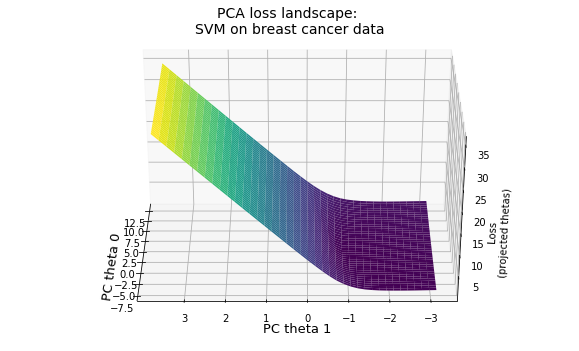

In [79]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

ax.plot_surface(theta_0_points, theta_1_points, loss, cmap='viridis')
ax.set_title('PCA loss landscape: \nSVM on breast cancer data',
             fontsize=14)
ax.set_xlabel('PC theta 0', fontsize=13)
ax.set_ylabel('PC theta 1', fontsize=13)
ax.set_zlabel('Loss \n(projected thetas)')
ax.view_init(30, 180)

Saving theta and loss point values

In [80]:
df = pd.DataFrame({'theta_0': theta_0_points.reshape(num_samples**2),
                   'theta_1': theta_1_points.reshape(num_samples**2),
                   'loss': loss.reshape(num_samples**2)},
                  columns = ['theta_0', 'theta_1', 'loss'])
df.to_csv('data/PCA_loss_SVM_cancer.csv', index=False)